In [2]:
import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
world = pd.read_csv('world.csv',encoding = 'ISO-8859-1')
life = pd.read_csv('life.csv',encoding = 'ISO-8859-1')

w_data = pd.merge(world[:-5], life, on='Country Code', how='outer')
w_data.drop(w_data.columns[[0,1,2,23,24]], axis=1, inplace=True)

# remove the rows that do not have a class label
w_data = w_data[w_data['Life expectancy at birth (years)'].notna()]

for column in w_data.columns[:-1]:
    # replace nan cells as empty string
    w_data[column].replace(['...','..'], np.nan, inplace=True)
    median = w_data[column].median()
    w_data[column].replace(np.nan, median, inplace=True)

life_data = w_data.iloc[:,-1]

# convert values in the feature columns to float
w_data = w_data[w_data.columns[:-1]].astype(float)

w_data['Life expectancy at birth (years)'] = life_data

In [4]:
# feature generation using interaction term pairs
feature = pd.DataFrame()

for i in range(len(w_data.iloc[:,:-1].columns)):
    for j in range(i+1,20):
        f1 = w_data.columns[i]
        f2 = w_data.columns[j]
        col = f1+' and '+f2
        feature[col] = w_data[f1] * w_data[f2]

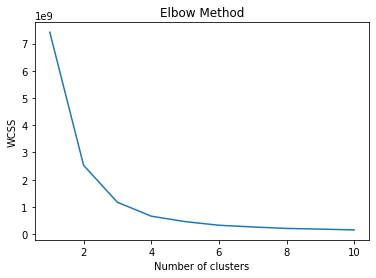

In [5]:
# elbow method to determine numbers of k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(w_data.iloc[:,:-1])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('task2bgraph1.png', bbox_inches='tight')

In [6]:
# feature generation using clustering labels
kmeans = KMeans(n_clusters=3)
kmeans.fit(w_data.iloc[:,:-1])
feature['clusterlabel'] = kmeans.predict(w_data.iloc[:,:-1])

# append all 211 features in the dataframe
for col in w_data.columns:
    feature[col] = w_data[col]
    
feature['Life expectancy at birth (years)'] = w_data['Life expectancy at birth (years)'] 

In [7]:
#randomly select 66% of the instances to be training and the rest to be testing
lifeclass = feature['Life expectancy at birth (years)']
fX_train, fX_test, fy_train, fy_test = train_test_split(feature.iloc[:,:-1], lifeclass, train_size=2/3, test_size=1/3, random_state=100)

# calculate normalised mutual information for each feature
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, mutual_info_score
mi_dict = {}
for col in feature.iloc[:,:-1].columns:
    mi = normalized_mutual_info_score(fX_train[col], fy_train)
    mi_dict[col] = mi
mi_df = pd.DataFrame(list(mi_dict.values()),columns = ['NMI'], index = mi_dict.keys())

# sort the NMI scores from highest to lowest
mi_df.sort_values(by = 'NMI',ascending = False, inplace = True) 

In [8]:
list(mi_df[:4].index)

['Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]',
 'Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS] and Mortality rate attributed to unintentional poisoning, female (per 100,000 female population) [SH.STA.POIS.P5.FE]',
 'Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS] and Mortality rate attributed to household and ambient air pollution, age-standardized, male (per 100,000 male population) [SH.STA.AIRP.MA.P5]',
 'Mortality rate attributed to household and ambient air pollution, age-standardized, male (per 100,000 male population) [SH.STA.AIRP.MA.P5] and Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population) [SH.STA.WASH.P5]']

In [16]:
# get the top 4 features with highest NMI
selected_f = feature[list(mi_df[:4].index)]
feX_train, feX_test, fey_train, fey_test = train_test_split(selected_f, lifeclass, train_size=2/3, test_size=1/3, random_state=100)
scaler2 = preprocessing.StandardScaler().fit(feX_train)
feX_train=scaler2.transform(feX_train)
feX_test=scaler2.transform(feX_test)

# k-NN (k=5) classification use features sort by MI
knn_fe = neighbors.KNeighborsClassifier(n_neighbors=5)
knn_fe.fit(feX_train, fey_train)
fey_pred=knn_fe.predict(feX_test)
print(f'Accuracy of feature engineering: {accuracy_score(fey_test, fey_pred):.3f}')

Accuracy of feature engineering: 0.770


In [17]:
pX_train, pX_test, py_train, py_test = train_test_split(feature.iloc[:,191:-1], lifeclass, train_size=2/3, test_size=1/3, random_state=100)

# normalise the data 
scaler1 = preprocessing.StandardScaler().fit(pX_train)
pX_train=scaler1.transform(pX_train)
pX_test=scaler1.transform(pX_test)

pca = PCA(n_components=4)
pX_train = pca.fit_transform(pX_train)
pX_test = pca.fit_transform(pX_test)

knn_pca = neighbors.KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(pX_train, py_train)
py_pred=knn_pca.predict(pX_test)
print(f'Accuracy of PCA: {accuracy_score(py_test, py_pred):.3f}')

Accuracy of PCA: 0.754


In [18]:
# k-NN (k=5) classification use the first four features 
ffX_train, ffX_test, ffy_train, ffy_test = train_test_split(feature.iloc[:,191:195], lifeclass, train_size=2/3, test_size=1/3, random_state=100)
scaler3 = preprocessing.StandardScaler().fit(ffX_train)
ffX_train=scaler3.transform(ffX_train)
ffX_test=scaler3.transform(ffX_test)
knn_ff = neighbors.KNeighborsClassifier(n_neighbors=5)
knn_ff.fit(ffX_train, ffy_train)
ffy_pred=knn_ff.predict(ffX_test)
print(f'Accuracy of first four features: {accuracy_score(ffy_test, ffy_pred):.3f}')

Accuracy of first four features: 0.754
